### Reconstructing the past: estimating solar radio flux F10.7 from sunspot records  
#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025

In [44]:
import numpy as np
import matplotlib.pyplot as plt

#### 2. Read data from the files and plot charts

In [45]:
radio_flux_data = np.loadtxt('data/Radio_flux_monthly_mean.txt')
radio_year = radio_flux_data[:, 0].astype(int)
radio_month = radio_flux_data[:, 1].astype(int)
radio_flux = radio_flux_data[:, 2]

sunspot_data = np.loadtxt('data/Sunspot_number_monthly_mean.txt')
sunspot_year = sunspot_data[:, 0].astype(int)
sunspot_month = sunspot_data[:, 1].astype(int)
sunspot_number = sunspot_data[:, 2]

#### 3. Plot the monthly mean sunspot numbers and solar radio flux F10.7 cm

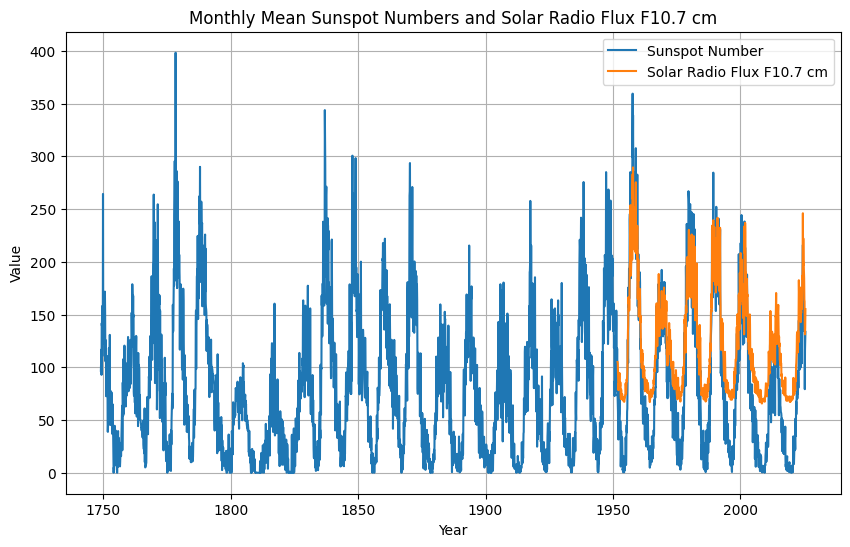

In [46]:
plt.figure(figsize=(10, 6))
time_radio = radio_year + (radio_month - 1) / 12
time_sunspot = sunspot_year + (sunspot_month - 1) / 12
plt.plot(time_sunspot, sunspot_number, label='Sunspot Number')
plt.plot(time_radio, radio_flux, label='Solar Radio Flux F10.7 cm')
plt.title('Monthly Mean Sunspot Numbers and Solar Radio Flux F10.7 cm')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### 4. Apply a 13-month running mean to smooth the monthly mean data for sunspot numbers and solar radio flux F10.7.

In [47]:
def running_mean_13(data):
    n = len(data)
    smoothed = np.zeros_like(data)
    for i in range(n):
        if i < 6:
            smoothed[i] = np.mean(data[0:i+6])
        elif i >= n - 6:
            smoothed[i] = np.mean(data[i-6:])
        else:
            left_edge = data[i-6] / 24.0
            middle_sum = np.sum(data[i-5:i+6]) / 12.0
            right_edge = data[i+6] / 24.0
            smoothed[i] = left_edge + middle_sum + right_edge
    return smoothed

radio_flux_smooth = running_mean_13(radio_flux)
sunspot_smooth = running_mean_13(sunspot_number)

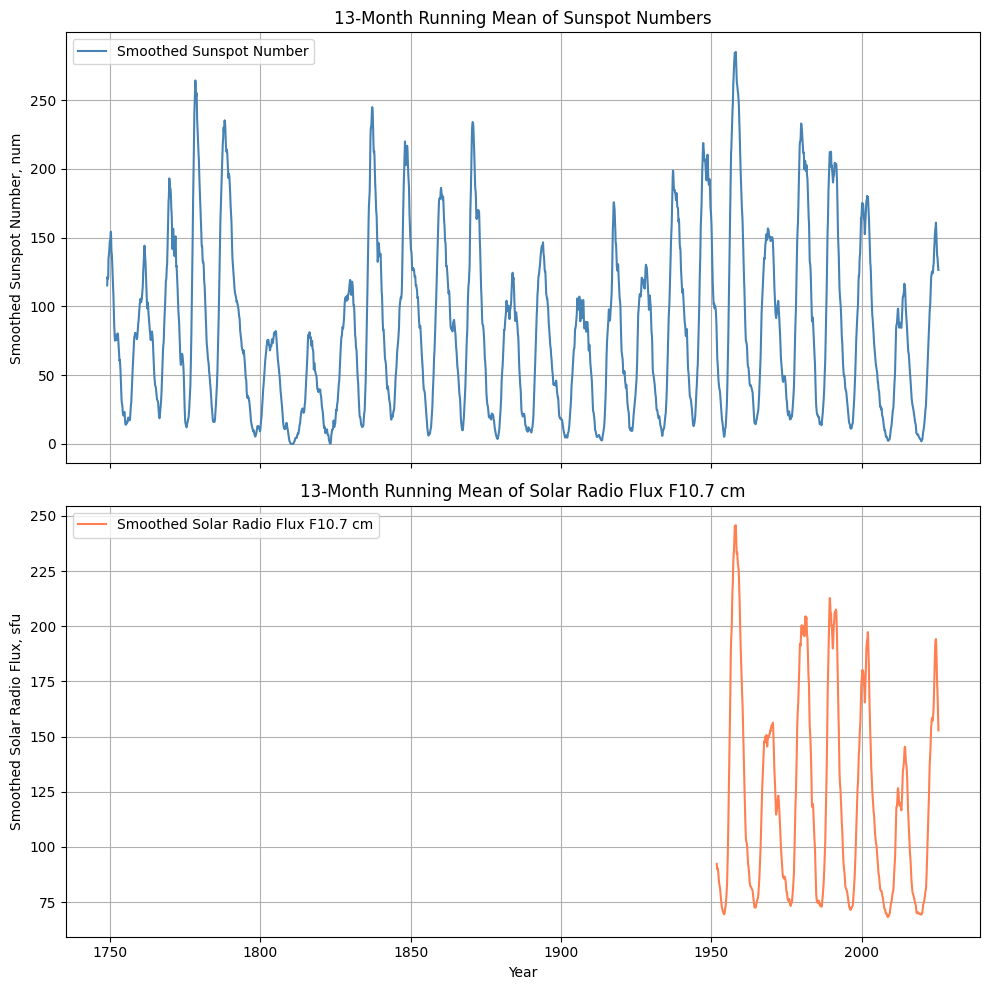

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Sunspot plot
ax1.plot(time_sunspot, sunspot_smooth, color='steelblue', label=f'Smoothed Sunspot Number')
ax1.set_title('13-Month Running Mean of Sunspot Numbers')
ax1.set_ylabel('Smoothed Sunspot Number, num')
ax1.legend()
ax1.grid(True)

# Radio flux plot
ax2.plot(time_radio, radio_flux_smooth, color='coral', label=f'Smoothed Solar Radio Flux F10.7 cm')
ax2.set_title('13-Month Running Mean of Solar Radio Flux F10.7 cm')
ax2.set_xlabel('Year')
ax2.set_ylabel('Smoothed Solar Radio Flux, sfu')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

#### 5. Scatter plot of the smoothed sunspot and F10.7 data.

###### Find overlapping period of data for scatter plot

In [49]:
radio_dates = set(zip(radio_year, radio_month))
sunspot_dates = set(zip(sunspot_year, sunspot_month))
overlap_dates = sorted(list(radio_dates.intersection(sunspot_dates)))

radio_indices = [np.where((radio_year == y) & (radio_month == m))[0][0] for y, m in overlap_dates]
sunspot_indices = [np.where((sunspot_year == y) & (sunspot_month == m))[0][0] for y, m in overlap_dates]

radio_overlap = radio_flux_smooth[radio_indices]
sunspot_overlap = sunspot_smooth[sunspot_indices]

###### Scatter plot of smoothed sunspot numbers vs solar radio flux


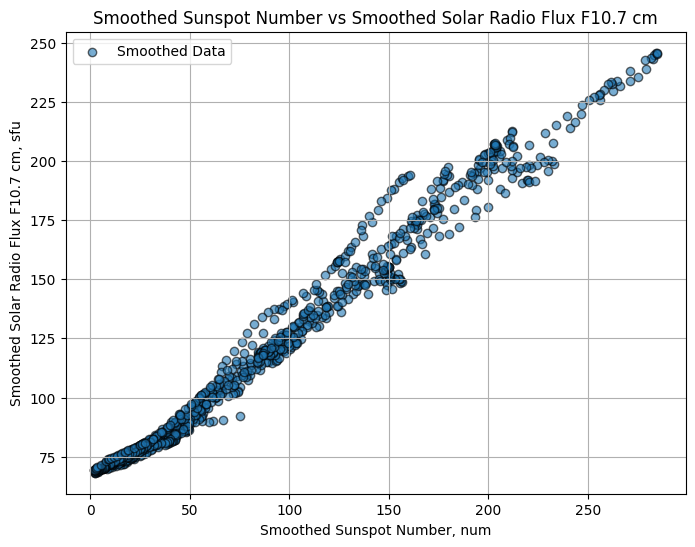

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(sunspot_overlap, radio_overlap, alpha=0.6, edgecolor='k', label='Smoothed Data')
plt.title('Smoothed Sunspot Number vs Smoothed Solar Radio Flux F10.7 cm')
plt.xlabel('Smoothed Sunspot Number, num')
plt.ylabel('Smoothed Solar Radio Flux F10.7 cm, sfu')
plt.legend()
plt.grid(True)
plt.show()

#### 6-7. Construction of multi-dimensional linear regression. Define the vectors

In [51]:
# Define regressand vector F (smoothed solar radio flux)
F = radio_flux_smooth[radio_indices]

# Define regressors matrix R (with columns: 1, R, R^2, R^3 from smoothed sunspot numbers)
R_sunspot = sunspot_smooth[sunspot_indices]
R = np.column_stack((np.ones(len(R_sunspot)),
                     R_sunspot,
                     R_sunspot**2,
                     R_sunspot**3))


#### 8. Determine the vector of coefficients using the Least Squares Method (LSM).

In [52]:
RtR = np.dot(R.T, R)
RtF = np.dot(R.T, F)
beta = np.linalg.inv(RtR).dot(RtF)
beta

array([ 6.57573867e+01,  4.67865728e-01,  1.96633736e-03, -5.21355660e-06])


#### 9. Reconstruct the smoothed solar radio flux at 10.7 cm

In [53]:
F_reconstructed = beta[0] + beta[1]*R_sunspot + beta[2]*R_sunspot**2 + beta[3]*R_sunspot**3

#### 10. Determine the root-mean square error (RMSE) of the reconstructed solar radio flux at 10.7 cm.

In [54]:
N = len(F)
rmse = np.sqrt(np.sum((F - F_reconstructed)**2) / (N - 1))
rmse

np.float64(6.277073803140485)

#### 11. Apply your model to earlier periods where only sunspot numbers are available. Add error bounds estimated as ±3σ,

/tmp/ipython-input-2052819601.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(radio_year + (radio_month - 1)/12, radio_flux, 'r--', color='coral', label='Original Solar Radio Flux (for overlap period)')


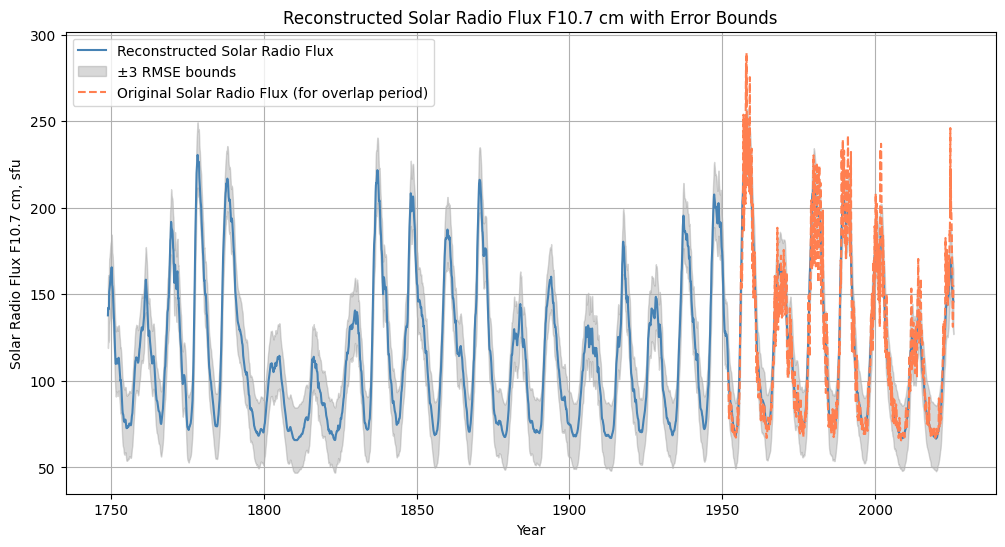

In [55]:
F_full_reconstructed = beta[0] + beta[1]*sunspot_smooth + beta[2]*sunspot_smooth**2 + beta[3]*sunspot_smooth**3

# Calculate error bounds ±3*rmse
upper_bound = F_full_reconstructed + 3*rmse
lower_bound = F_full_reconstructed - 3*rmse

# Plot reconstruction with error bounds
plt.figure(figsize=(12, 6))
full_time = sunspot_year + (sunspot_month - 1)/12
plt.plot(full_time, F_full_reconstructed, color='steelblue', label='Reconstructed Solar Radio Flux')
plt.fill_between(full_time, lower_bound, upper_bound, color='gray', alpha=0.3, label='±3 RMSE bounds')
plt.plot(radio_year + (radio_month - 1)/12, radio_flux, 'r--', color='coral', label='Original Solar Radio Flux (for overlap period)')
plt.title('Reconstructed Solar Radio Flux F10.7 cm with Error Bounds')
plt.xlabel('Year')
plt.ylabel('Solar Radio Flux F10.7 cm, sfu')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion